In [3]:
import os
import sys
import ast
import time
sys.path.append('.')
sys.path.append('../')
import numpy as np
import pandas as pd
import json


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.utils.io import (get_matched_data_path,
                          get_matched_metadata_path,
                          get_matched_summary_path,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                          get_figures_dir,
                          get_project_root,
                          get_results_dir,
                          )

from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)
# from src.utils.plot import plot_raw_time_series

# from src.utils.data import (create_data_tensors,
#                             adjust_behavior_and_durations,
#                             create_data_tensors,
#                             create_matched_data,
#                             setup_multilabel_dataloaders)
                            
from src.utils.data_prep import (combined_annotations,
                                create_matched_data,
                                create_max_windows,
                                create_summary_data,
                                create_data_splits,
                                setup_dataloaders,
                                give_balanced_weights)

from config.settings import (RAW_COLLAPSE_BEHAVIORS_MAPPING_W_TROTTING,
                             RAW_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING,
                            RAW_BEHAVIORS_WO_TROTTING,
                             SAMPLING_RATE,
                             id_mapping,)

from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix


In [4]:
# Graphing Parameters
import matplotlib as mpl

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [5]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = combined_annotations(video_path=get_video_labels_path(), 
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

all_annotations.columns

Index(['id', 'Behavior', 'Timestamp_start', 'Timestamp_end', 'Source'], dtype='object')

In [6]:
all_annotations.Timestamp_start = pd.to_datetime(all_annotations.Timestamp_start)
all_annotations.Timestamp_end = pd.to_datetime(all_annotations.Timestamp_end)
all_annotations['duration'] = (all_annotations.Timestamp_end - all_annotations.Timestamp_start).dt.total_seconds()
all_annotations['Behavior'] = all_annotations['Behavior'].replace(RAW_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING)
all_annotations = all_annotations[all_annotations.Behavior.isin(RAW_BEHAVIORS_WO_TROTTING)]

In [7]:
print(all_annotations["duration"].describe())
value = 30
quantile = np.mean(all_annotations["duration"] <= value)
print(f"Value {value}s is approximately at the {quantile*100:.2f}th percentile.")

count    10170.000000
mean        32.534612
std         96.290787
min          0.000000
25%          3.000000
50%          8.000000
75%         23.000000
max       2466.000000
Name: duration, dtype: float64
Value 30s is approximately at the 80.03th percentile.


80.57% of the behavior annotations are shorter than 30 seconds in duration. In fact, the median duration is just 8 seconds.

In [8]:
metadata = pd.read_csv(get_metadata_path())

In [ ]:
min_durations_list = [10, 20, 30, 40]

for min_duration in min_durations_list:

    summary_dir = os.path.join(get_project_root(), 'data', f"duration{min_duration}")
    data_dir = os.path.join(get_project_root(), 'data', f"duration{min_duration}")
    metadata_dir = os.path.join(get_project_root(), 'data', f"duration{min_duration}")

    os.makedirs(summary_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(metadata_dir, exist_ok=True)

    summary_path = os.path.join(summary_dir, "matched_acc_summary.csv")
    data_path = os.path.join(data_dir, "matched_acc_data.csv")
    metadata_path = os.path.join(metadata_dir, "matched_acc_metadata.csv")


    if not (os.path.exists(summary_path) and os.path.exists(data_path) and os.path.exists(metadata_path)):
        acc_summary, acc_data, acc_data_metadata = create_matched_data(
            metadata, all_annotations, min_duration=min_duration, verbose=True
        )
        acc_summary.to_csv(summary_path, index=False)
        acc_data.to_csv(data_path, index=False)
        acc_data_metadata.to_csv(metadata_path, index=False)
    else:
        acc_summary = pd.read_csv(summary_path)
        acc_data = pd.read_csv(data_path)
        acc_data_metadata = pd.read_csv(metadata_path)

        acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
        acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
        acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)


In [ ]:
acc_data = pd.read_csv(os.path.join(get_project_root(), 'data', "duration30", "matched_acc_data.csv"))


acc_data_split = create_max_windows(acc_data=acc_data, window_duration=30.0, sampling_rate=SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]
split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)
print(f"Total {np.sum(np.isnan(acc_data_split.acc_x_ptp_max.values))} annotations have duration less than 2 seconds")

Total 0 annotations have duration less than 2 seconds


In [11]:
split_acc_data.groupby('behavior')['behavior'].count()/len(split_acc_data)

behavior
Feeding       0.022664
Moving        0.136747
Running       0.012991
Stationary    0.827598
Name: behavior, dtype: float64

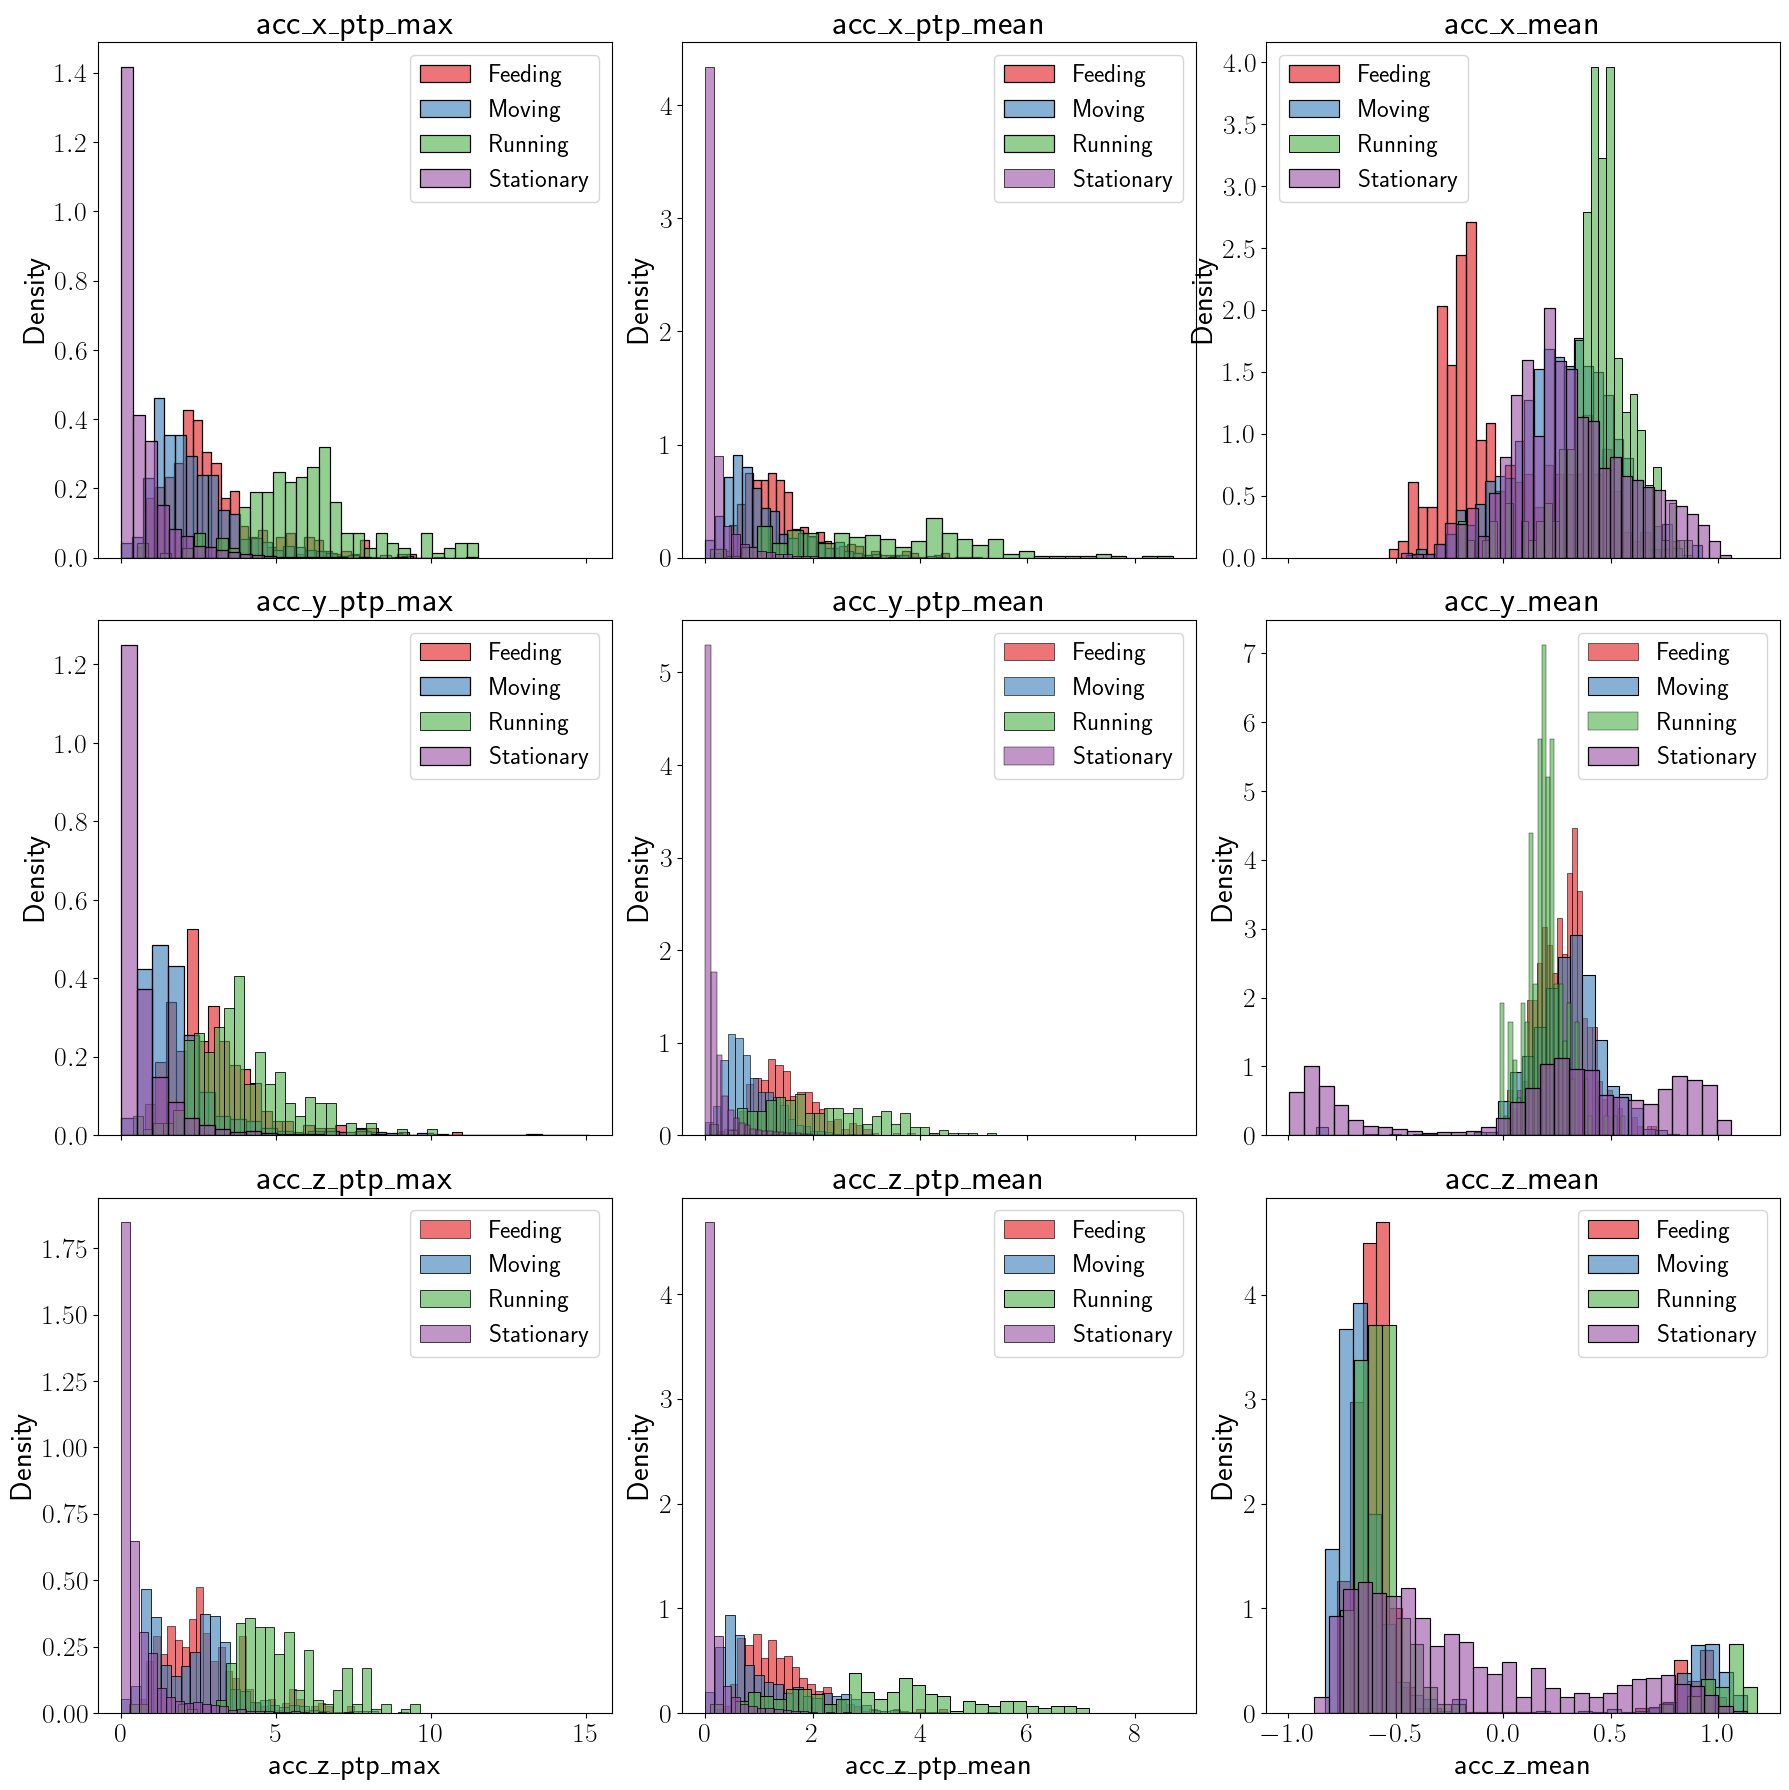

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(BEHAVIORS))

behaviors_to_plot = acc_data_split['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean', 'mean']

for i, axis in enumerate(acc_axes):
    for j, feature in enumerate(features):

        feature = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(BEHAVIORS):
            sns.histplot(
                acc_data_split[acc_data_split['behavior'] == behavior][feature],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                bins=30,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)

        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()


In [15]:
from dataclasses import dataclass, field
from typing import  List

@dataclass
class TrainArgs:
    batch_size: int = 32
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [64])
    dropout_rate: float = 0.5

@dataclass
class DataArgs:
    min_duration: float = 30.0

train_args = TrainArgs()
model_args = ModelArgs()
data_args = DataArgs()

In [16]:
training_results_dir = os.path.join(get_results_dir(), 'training_results')
os.makedirs(training_results_dir, exist_ok=True)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
feature_cols = [
    'acc_x_ptp_max', 'acc_x_ptp_mean', 'acc_x_mean',
    'acc_y_ptp_max', 'acc_y_ptp_mean','acc_y_mean',
    'acc_z_ptp_max', 'acc_z_ptp_mean', 'acc_z_mean',
]

In [70]:
min_durations_list = [10]
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for min_duration in min_durations_list:

    data_args.min_duration = min_duration
    # read acceleration data
    data_path = os.path.join(get_project_root(), 'data', 'duration'+str(data_args.min_duration), "matched_acc_data.csv")
    acc_data = pd.read_csv(data_path)
    acc_data['acc_x'] = acc_data['acc_x'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))
    acc_data['acc_y'] = acc_data['acc_y'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))
    acc_data['acc_z'] = acc_data['acc_z'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))

    # split it in min_duration chunks
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=data_args.min_duration, sampling_rate=SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]

    # create summary statistics data
    split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

    # create train, val, and test splits
    X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(acc_data_split, feature_cols=feature_cols)

    for theta in theta_list:

        train_args.theta = theta

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(BEHAVIORS), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{train_args.theta}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

Epoch 100/100 | Train Loss: 0.1051 | Val Loss: 0.1034 | Best val Loss: 0.1030: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Total training time: 0:01:17


Epoch 100/100 | Train Loss: 0.1410 | Val Loss: 0.1068 | Best val Loss: 0.1061: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Total training time: 0:01:20


Epoch 100/100 | Train Loss: 0.1596 | Val Loss: 0.1146 | Best val Loss: 0.1126: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1742 | Val Loss: 0.1234 | Best val Loss: 0.1220: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Total training time: 0:01:19


Epoch 100/100 | Train Loss: 0.1775 | Val Loss: 0.1406 | Best val Loss: 0.1319: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Total training time: 0:01:23


Epoch 100/100 | Train Loss: 0.1887 | Val Loss: 0.1618 | Best val Loss: 0.1458: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

Total training time: 0:01:21


In [23]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)

LabelEncoder()

/tmp/ipykernel_153838/998706376.py:27: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


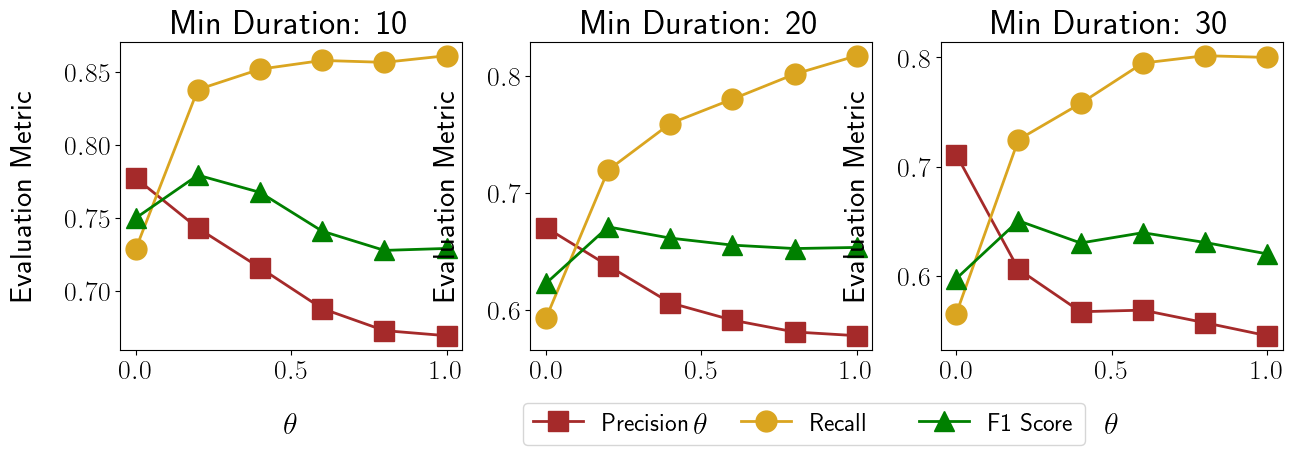

In [69]:
fig, axs = plt.subplots(1, len(min_durations_list), figsize=(5*len(min_durations_list), 4), sharey=True)
colors = ['brown', 'goldenrod', 'green']
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

min_durations_list = [10, 20, 30]

for i, min_duration in enumerate(min_durations_list):
    
    precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

    for j, theta in enumerate(theta_list):

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")

        precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

    axs[i].plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
    axs[i].plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
    axs[i].plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
    axs[i].set_title(f"Min Duration: {min_duration}")
    axs[i].set_xlabel(r'$\theta$', labelpad=20)
    axs[i].set_ylabel('Evaluation Metric', labelpad=20)

axs[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(2.0,-0.35))
plt.tight_layout()
plt.show()  

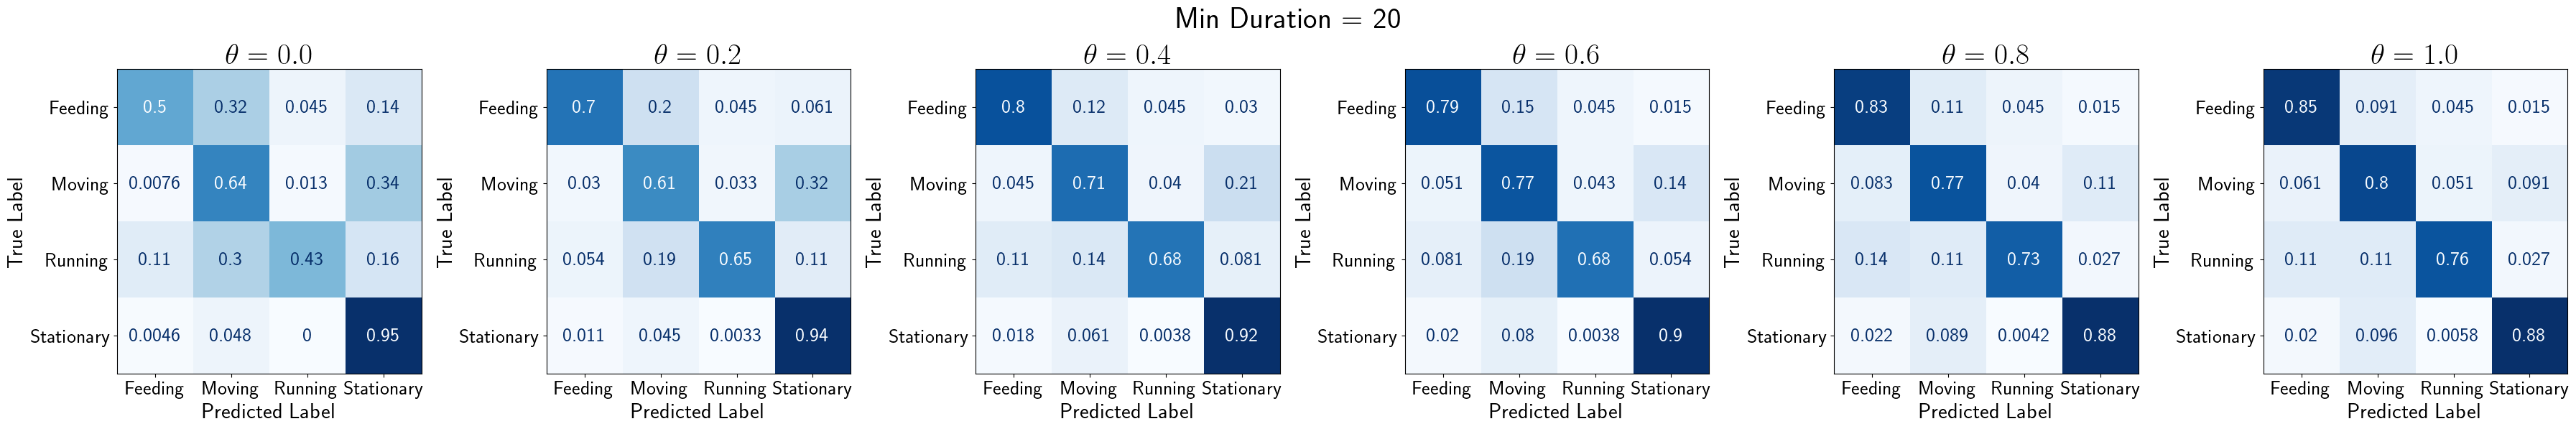

In [58]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
min_duration = 20

fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 6))

for i, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_, 
    )
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)

    # Optional: format text size
    for text in disp.text_.ravel():
        text.set_fontsize(20)

    axs[i].set_title(f"$\\theta = {theta}$", fontsize=30)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

fig.suptitle(f"Min Duration = {min_duration}", fontsize=30)
plt.tight_layout()
plt.show()

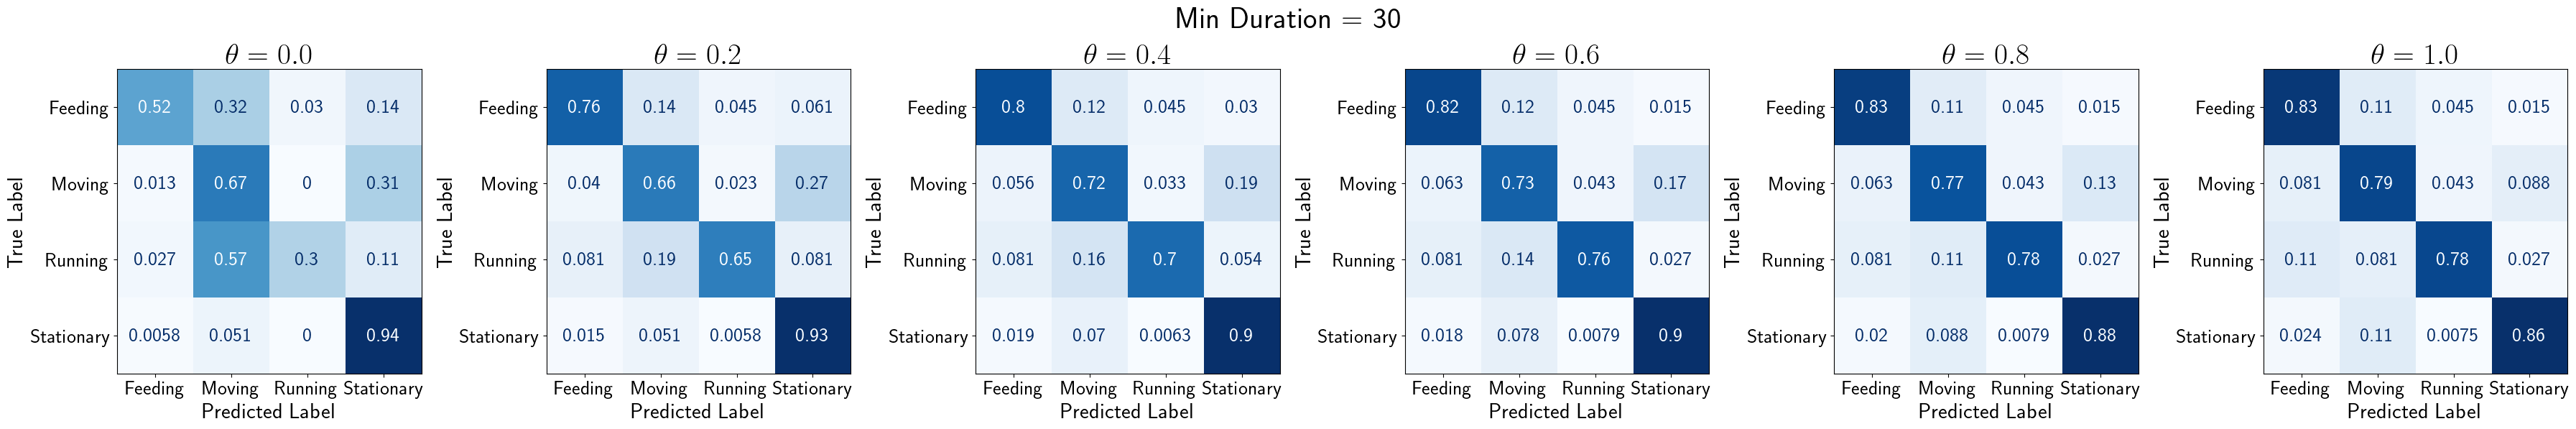

In [59]:
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 6))
min_duration = 30

for i, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_, 
    )
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)

    # Optional: format text size
    for text in disp.text_.ravel():
        text.set_fontsize(20)

    axs[i].set_title(f"$\\theta = {theta}$", fontsize=30)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

fig.suptitle(f"Min Duration = {min_duration}", fontsize=30)
plt.tight_layout()
plt.show()